In [1]:
#IMPORTING MODULES

import numpy as np
import pandas as pd
import os
from astropy.timeseries import LombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import shutil
from astropy.utils.data import _get_download_cache_loc

from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs

import scipy as sp

In [2]:
### PRELIMINARY STUFF

#Raw table
raw_table = pd.read_csv("tess_sector_91_92.csv",skiprows=[0, 1],names=["update_date","main_id","TICID","gaiadr3_id","CCD","Tmag","RA","Dec","sector","count","sp_type","sp_qual","plx_value","V","B","G","otype","nbref","rvz_radvel","rvz_redshift","gaiadr3_plx","gaiadr3phot_g_mean_mag","gaiadr3_bp_rp","abs_mag_rough"])

#Creating scuti line
point_1 = (0.24,2)
point_2 = (0.12,4)

m = (point_1[1]-point_2[1])/(point_1[0] - point_2[0])
b= (point_1[1]-m*point_1[0])
#tolerance = 5 #height of diagonal band
tolerance = 7

#creating boolean mask
raw_table['gaiadr3_bp_rp'] = pd.to_numeric(raw_table['gaiadr3_bp_rp'], errors='coerce')
raw_table['abs_mag_rough'] = pd.to_numeric(raw_table['abs_mag_rough'], errors='coerce')
raw_table.dropna(subset=['gaiadr3_bp_rp', 'abs_mag_rough'], inplace=True)


diagonal_mask = (abs(raw_table['abs_mag_rough'] - (m * raw_table['gaiadr3_bp_rp'] + b)) <= tolerance)

filtered_table = raw_table[diagonal_mask]

#Creating List of Chosen TICIDs
tic_ids = filtered_table['TICID']

id_list = tic_ids.tolist()

int_id_list = [int(f) for f in id_list]

print(len(int_id_list))

158


In [3]:
#GRAPHICAL ANALYSIS **************

#search function

def selective_search(tic_id):
    search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS')

    if not search_result:
        print(f"⚠️ No TESS light curves found for TIC {tic_id}.")
        return None
    
    try:
        selec_search = search_result[search_result.author == 'SPOC']
        exptimes = selec_search.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = selec_search[min_index]
    except:
        print("No Spoc result found")
        exptimes = search_result.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = search_result[min_index]
        
    return parsed_search

#downloading data and removing bad data points function

def dwnlwd(parsed_search):
    data = parsed_search.download(quality_bitmask='default').remove_nans()
    return data

#Removing Outliers
def outlier_remover(data):
    return data.remove_outliers(5)

#Extracting and normalising data
def extracter(data):
    #.remove_outliers()
    
    time, flux = data.time.value, data.flux.value
    flux /= np.median(flux)
    time -= time[0]

    return time, flux

#Fourier Transform function
def calc_lomb_scargle(t,y):
    oversample = 10 # can be adjusted
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    fmin = df
    fmax = 1000 # set max freq in c/d

    freq = np.arange(fmin, fmax, df / oversample)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct * 1e6
    return freq, amp # freq in cycles per day and amp in ppm

#skewness
def skewness(freq, amp):
    mask = (freq > 5) & (freq <70)
    freq_filtered = freq[mask]
    amp_filtered = amp[mask]
    
    skew = sp.stats.skew(amp_filtered)

    return skew

#signal to noise ratio
def signalnoise(freq, amp):
    #mask = (freq > 5)
    mask = (freq > 5) & (freq <70)
    freq_filtered = freq[mask]
    amp_filtered = amp[mask]

    # Identify the highest peak in the filtered region
    highest_peak_index = np.argmax(amp_filtered)
    freq_highest = freq_filtered[highest_peak_index]

    # Define noise region: 60–70 cycles per day
    noise_mask = (freq >= 60) & (freq <= 70)
    noise_amps = amp[noise_mask]
    noise_level = np.mean(noise_amps)

    # Compute SNR
    snr_highest_peak = amp_filtered[highest_peak_index] / noise_level

    return snr_highest_peak

#Compiling Function
def pulsator(tic_id):

    parsed_search_result = selective_search(tic_id)

    if parsed_search_result == None:
        return
    
    data = dwnlwd(parsed_search_result)

    data_stripped = outlier_remover(data)

    time, flux = extracter(data_stripped)

    freq, amp = calc_lomb_scargle(time, flux)

    snr = signalnoise(freq,amp)

    skew = skewness(freq,amp)

    return tic_id, snr, skew



In [4]:
### Testing

pulsator(346156382)

(346156382, 3.300717148614129, 0.6787243133591836)

In [5]:
def compile_results(int_id_list):
    results = []

    for tic_id in int_id_list:
        try:
            result = pulsator(tic_id)
            if result is not None:
                results.append(result)
        except Exception as e:
            print(f"⚠️ Error processing TIC {tic_id}: {e}")

    # Convert to numpy array
    results_array = np.array(results)
    
    return results_array

In [7]:
spectrum_stats = compile_results(int_id_list)

No Spoc result found


/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folde

No Spoc result found


/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folde

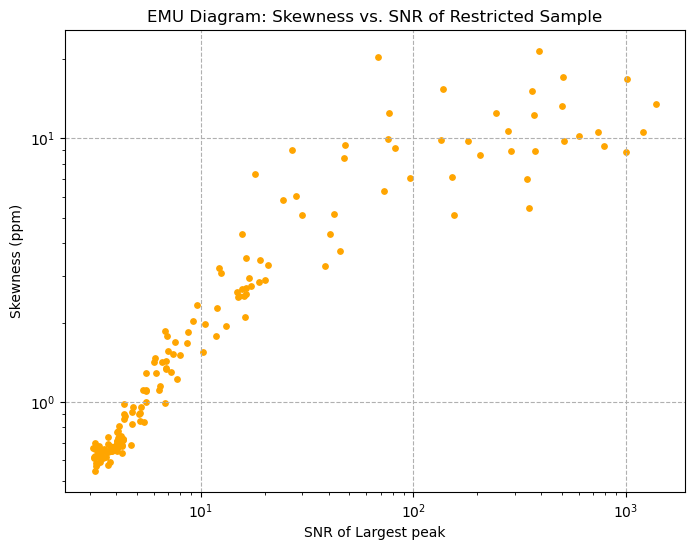

In [8]:
#emu diagram

snr = spectrum_stats[:, 1]
skew = spectrum_stats[:, 2]

plt.figure(figsize=(8, 6))

scatter = plt.scatter(snr, skew, c = 'orange', s=15)

plt.xlabel("SNR of Largest peak")
plt.ylabel("Skewness (ppm)")
plt.title("EMU Diagram: Skewness vs. SNR of Restricted Sample")
plt.xscale('log')
plt.yscale('log')
plt.savefig('emudiagram.png',dpi = 300)
plt.grid(True, linestyle='--')
plt.show()

In [9]:
#SCUTI STATS
dscuti_tic = [334177803, 333077513, 418824772, 168829745, 19924794, 71859994, 288404080, 420896293, 77390459, 155745933, 155772218, 410540533, 126006658, 70367797, 206144150, 413731775, 73806092, 214611227, 368759, 225709409, 381822792, 259365501, 288143236, 186287370, 49069582]

scuti_stats = compile_results(dscuti_tic)

/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_28423/2470401051.py:59: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6


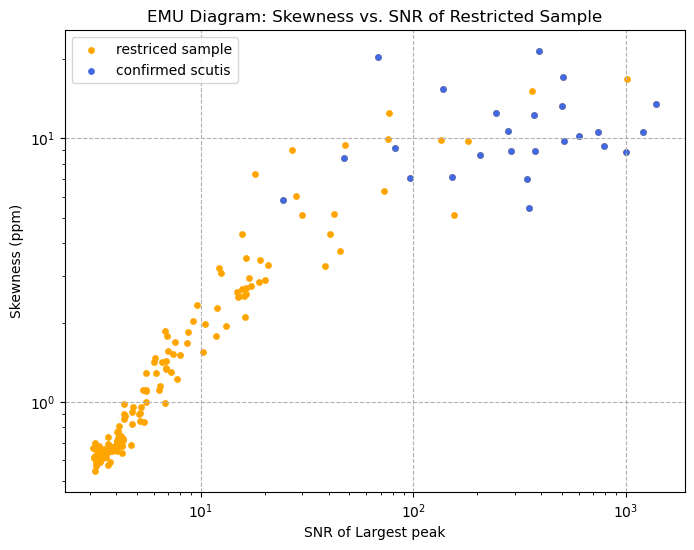

In [10]:
#emu diagram with scutis plotted

snr_scuti = scuti_stats[:, 1]
skew_scuti = scuti_stats[:, 2]

snr = spectrum_stats[:, 1]
skew = spectrum_stats[:, 2]

plt.figure(figsize=(8, 6))

scatter = plt.scatter(snr, skew, c = 'orange', s=15, label = 'restriced sample')
scatter = plt.scatter(snr_scuti, skew_scuti, c = 'royalblue', s=15, label = 'confirmed scutis')

plt.xlabel("SNR of Largest peak")
plt.ylabel("Skewness (ppm)")
plt.title("EMU Diagram: Skewness vs. SNR of Restricted Sample")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('emudiagramscuti.png',dpi = 300)
plt.grid(True, linestyle='--')
plt.show()

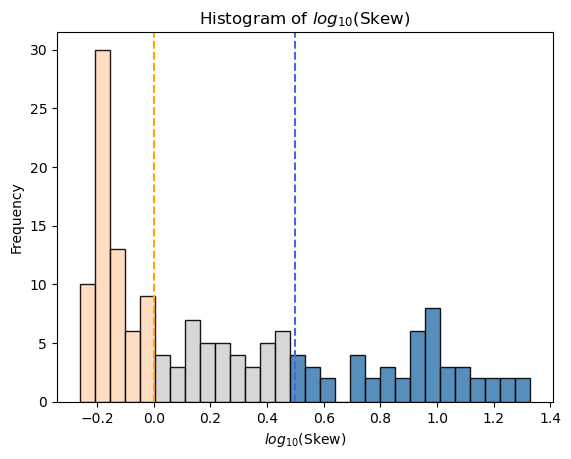

In [11]:
#histogram

log_skew = np.log10(skew)

counts, bins, patches = plt.hist(log_skew, bins=30, edgecolor='black', alpha=0.9)

# Color bins conditionally
for i, patch in enumerate(patches):
    # each patch corresponds to a bin spanning bins[i] to bins[i+1]
    bin_center = (bins[i] + bins[i+1]) / 2
    if bin_center < 0:
        patch.set_facecolor('peachpuff')   # left of orange line
    elif bin_center > 0.5:
        patch.set_facecolor('steelblue')   # right of blue line
    else:
        patch.set_facecolor('lightgray')   # in between (optional)


plt.title(r"Histogram of $log_{10}$(Skew)")
plt.ylabel("Frequency")
plt.xlabel(r"$log_{10}$(Skew)")
plt.axvline(0, color='orange', linestyle='--', linewidth=1.5)
plt.axvline(0.5, color='royalblue', linestyle='--', linewidth=1.5)
plt.savefig("emuhist.png",dpi = 300)
plt.show()


In [12]:
#divide stars into lists based upon their location in the histogram

def classify_pulsators(results_array, left_line=0.0, right_line=0.5):
    tic_ids = results_array[:, 0].astype(int)
    skew = results_array[:, 2]

    # Compute log10(skew) safely (avoid negative/zero values)
    valid_mask = skew > 0
    log_skew = np.full_like(skew, np.nan)
    log_skew[valid_mask] = np.log10(skew[valid_mask])

    # Create lists
    non_pulsating = []
    maybe = []
    pulsating = []

    for i, log_s in enumerate(log_skew):
        if np.isnan(log_s):
            continue  # skip invalid
        if log_s < left_line:
            non_pulsating.append(tic_ids[i])
        elif log_s > right_line:
            pulsating.append(tic_ids[i])
        else:
            maybe.append(tic_ids[i])

    return non_pulsating, maybe, pulsating

In [13]:
non_list, maybe_list, pulse_list = classify_pulsators(spectrum_stats)

In [14]:
print(non_list)
print(len(non_list))

[75899957, 214558913, 420895269, 48774605, 352487147, 186642657, 99389357, 73852746, 49549335, 325862858, 187064019, 429344309, 428790951, 333393998, 161522892, 442481598, 411034621, 155157963, 842202, 48908494, 410485468, 228096158, 52694280, 49038679, 3375779, 422688328, 434613683, 421698631, 432267234, 302873827, 290110180, 99665635, 70748511, 214565306, 183921054, 466087197, 433927997, 127847922, 70807009, 69983490, 326300081, 206233701, 437389783, 335303863, 2173506, 181584365, 385430433, 92030008, 73601124, 302728986, 333461689, 49696160, 187914009, 192622163, 224463111, 71058372, 68047964, 191149891, 346156382, 621750, 379958045, 441028857, 68165184, 192655640, 24845551, 82657890, 80867125, 24266783]
68


In [15]:
print(maybe_list)
print(len(maybe_list))

[417526469, 181290095, 444057141, 422736099, 206238826, 442202726, 145740988, 422856892, 18809756, 12056898, 147755337, 308437152, 12515279, 243856698, 1286643, 25302877, 99415106, 46095850, 205960857, 5520036, 422364664, 442402171, 24189282, 294268836, 345121242, 48760373, 379554676, 114721100, 171275274, 99766307, 81375040, 22424895, 67756034, 68505142, 162132187, 6226963, 270467446, 198041404, 206253420, 345985243, 50171166, 203822414, 5976776]
43


In [16]:
print(pulse_list)
print(len(pulse_list))

[152859121, 322928423, 334177803, 204191276, 429674236, 333077513, 418824772, 168829745, 351985764, 192680424, 220466985, 19924794, 71859994, 288404080, 441018038, 420896293, 77390459, 155745933, 442508593, 155772218, 410540533, 126006658, 70367797, 398863845, 68637413, 206144150, 413731775, 73806092, 214611227, 368759, 203822321, 99371010, 49435315, 225709409, 61447354, 68052001, 381822792, 203307252, 259365501, 323181418, 280156638, 46040297, 288143236, 186287370, 49069582, 301679207, 333075410]
47


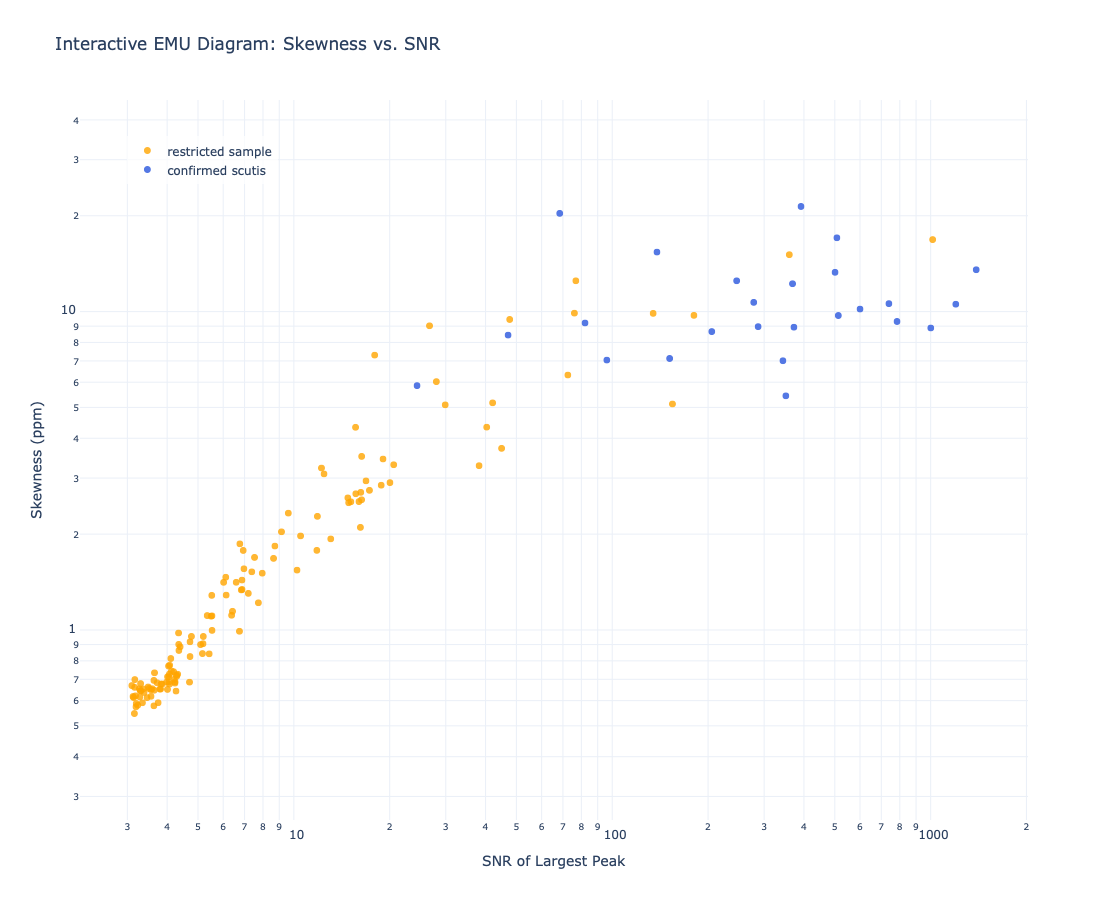

In [17]:
import plotly.graph_objects as go

tic = spectrum_stats[:, 0].astype(int)
snr = spectrum_stats[:, 1]
skew = spectrum_stats[:, 2]

confirmed_scutis = np.array([334177803, 333077513, 418824772, 168829745, 19924794, 71859994, 288404080, 420896293, 77390459, 155745933, 155772218, 410540533, 126006658, 70367797, 206144150, 413731775, 73806092, 214611227, 368759, 225709409, 381822792, 259365501, 288143236, 186287370, 49069582]
)

# Masks
scuti_mask = np.isin(tic, confirmed_scutis)
restricted_mask = ~scuti_mask

# Create Plotly figure
fig = go.Figure()

# Add restricted sample (non-scutis)
fig.add_trace(go.Scatter(
    x=snr[restricted_mask],
    y=skew[restricted_mask],
    mode='markers',
    name='restricted sample',
    marker=dict(color='orange', size=7, opacity=0.8),
    text=[f"TIC {i}" for i in tic[restricted_mask]],
    hovertemplate="TIC ID: %{text}<br>SNR: %{x:.2f}<br>Skewness: %{y:.2f} ppm"
))

# Add confirmed scutis
fig.add_trace(go.Scatter(
    x=snr[scuti_mask],
    y=skew[scuti_mask],
    mode='markers',
    name='confirmed scutis',
    marker=dict(color='royalblue', size=7, opacity=0.9),
    text=[f"TIC {i}" for i in tic[scuti_mask]],
    hovertemplate="TIC ID: %{text}<br>SNR: %{x:.2f}<br>Skewness: %{y:.2f} ppm"
))

# Log-log axes and layout styling
fig.update_layout(
    title="Interactive EMU Diagram: Skewness vs. SNR",
    xaxis=dict(
        title="SNR of Largest Peak",
        type="log"
    ),
    yaxis=dict(
        title="Skewness (ppm)",
        type="log",
        scaleanchor="x",   # locks y scale to x scale
        scaleratio=1       # keeps 1:1 aspect ratio
    ),
    legend=dict(
        x=0.05, y=0.95,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='gray'
    ),
    width=900,   # make figure larger
    height=900,  # square aspect ratio
    template="plotly_white"
)

fig.show()
